# Modeling

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from keras.models import Sequential
from keras.layers import LSTM, GRU, SimpleRNN
from keras.layers import Dense, Dropout, Normalization, BatchNormalization, LayerNormalization, Input
from tcn import TCN, tcn_full_summary
from catboost import CatBoostRegressor


from sklearn.preprocessing import MinMaxScaler

## Prepare the Data Sets
We want to create two separate datasets; one for our CatBoost model and one for our Keras models.

In [2]:
df = pd.read_parquet("../data/structured/general/combined_data.parquet")
df = df.dropna()
df

,Unit_4_Power,Unit_4_Reactive Power,Turbine_Guide Vane Opening,Turbine_Pressure Drafttube,Turbine_Pressure Spiral Casing,Turbine_Rotational Speed,Bolt_1_Tensile,Bolt_2_Tensile,Bolt_3_Tensile,Bolt_4_Tensile,...,Power / vane opening,seconds_since_last_data,seconds_since_last_start,Power / Drafttube pressure,Bolt_1_Tensile_adj,Bolt_2_Tensile_adj,Bolt_3_Tensile_adj,Bolt_4_Tensile_adj,Bolt_5_Tensile_adj,Bolt_6_Tensile_adj
timepoints,,,,,,,,,,,,,,,,,,,,,
1970-12-19 09:51:45,262.104319,3.344630,82.277248,173.989815,5311.219755,107.964273,1598.477449,1480.989528,1684.261611,1601.366508,...,3.185623,1.0,1.0,1.506435,115.477449,43.989528,72.261611,3.366508,6.588478,38.823883
1970-12-19 09:51:46,262.004330,3.790223,82.274520,174.024413,5311.640329,107.964269,1598.479316,1481.003188,1684.270504,1601.374254,...,3.184514,1.0,2.0,1.505561,115.479316,44.003188,72.270504,3.374254,6.583464,38.841318
1970-12-19 09:51:47,261.904340,4.235817,82.271792,174.059012,5312.060902,107.964264,1598.490184,1481.028827,1684.270683,1601.383179,...,3.183404,1.0,3.0,1.504687,115.490184,44.028827,72.270683,3.383179,6.581384,38.843245
1970-12-19 09:51:48,261.804351,4.064759,82.269064,174.153819,5312.405938,107.964259,1598.494073,1481.059017,1684.271062,1601.378391,...,3.182294,1.0,4.0,1.503294,115.494073,44.059017,72.271062,3.378391,6.591746,38.872300
1970-12-19 09:51:49,261.704362,3.170510,82.266336,174.422046,5312.533396,107.964254,1598.498916,1481.075521,1684.276622,1601.380601,...,3.181184,1.0,5.0,1.500409,115.498916,44.075521,72.276622,3.380601,6.607884,38.924469
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1971-01-25 11:06:44,308.716025,3.974309,94.425666,157.927905,5280.929965,108.057498,1637.386115,1504.557822,1701.651420,1606.276545,...,3.269408,1.0,19788.0,1.954791,154.386115,67.557822,89.651420,8.276545,11.704071,54.014705
1971-01-25 11:06:45,308.746393,4.103262,94.429003,157.974925,5280.633358,108.057492,1637.365865,1504.546091,1701.654301,1606.271877,...,3.269614,1.0,19789.0,1.954401,154.365865,67.546091,89.654301,8.271877,11.711250,54.017029
1971-01-25 11:06:46,308.776762,4.472929,94.432340,158.021945,5280.336751,108.057486,1637.384133,1504.538696,1701.656143,1606.250028,...,3.269820,1.0,19790.0,1.954012,154.384133,67.538696,89.656143,8.250028,11.699142,54.002008


In [3]:
y_cols = [c for c in df if c.endswith("Tensile")]
adj_cols = [c for c in df if c.endswith("Tensile_adj")]

### Create CatBoost dataset

In [4]:
extra_cols = ["seconds_since_start", "month", "day_of_month", "day_of_week"]

In [ ]:
X_cols = [
    "days_since_start",
    "Turbine_Pressure Drafttube",
    "seconds_since_last_start",
    ""
]

In [14]:
lookback = 0

cX = df.drop(columns=y_cols+adj_cols)
X_cols = cX.drop(columns=extra_cols).columns
for i in range(1, lookback+1):
    cX.loc[:, [f"{c} (t-{i})" for c in X_cols]] = cX[X_cols].shift(i).rename(columns={c: f"{c} (t-{i})" for c in X_cols})

cy = df[y_cols]

cX

,Unit_4_Power,Unit_4_Reactive Power,Turbine_Guide Vane Opening,Turbine_Pressure Drafttube,Turbine_Pressure Spiral Casing,Turbine_Rotational Speed,seconds_since_start,month,day_of_month,day_of_week,is_starting,Netto Power,Power / vane opening,seconds_since_last_data,seconds_since_last_start,Power / Drafttube pressure
timepoints,,,,,,,,,,,,,,,,
1970-12-19 09:51:45,262.104319,3.344630,82.277248,173.989815,5311.219755,107.964273,1.0,12,19,5,0,258.759689,3.185623,1.0,1.0,1.506435
1970-12-19 09:51:46,262.004330,3.790223,82.274520,174.024413,5311.640329,107.964269,2.0,12,19,5,0,258.214106,3.184514,1.0,2.0,1.505561
1970-12-19 09:51:47,261.904340,4.235817,82.271792,174.059012,5312.060902,107.964264,3.0,12,19,5,0,257.668524,3.183404,1.0,3.0,1.504687
1970-12-19 09:51:48,261.804351,4.064759,82.269064,174.153819,5312.405938,107.964259,4.0,12,19,5,0,257.739592,3.182294,1.0,4.0,1.503294
1970-12-19 09:51:49,261.704362,3.170510,82.266336,174.422046,5312.533396,107.964254,5.0,12,19,5,0,258.533851,3.181184,1.0,5.0,1.500409
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1971-01-25 11:06:44,308.716025,3.974309,94.425666,157.927905,5280.929965,108.057498,2769300.0,1,25,0,0,304.741716,3.269408,1.0,19788.0,1.954791
1971-01-25 11:06:45,308.746393,4.103262,94.429003,157.974925,5280.633358,108.057492,2769301.0,1,25,0,0,304.643131,3.269614,1.0,19789.0,1.954401
1971-01-25 11:06:46,308.776762,4.472929,94.432340,158.021945,5280.336751,108.057486,2769302.0,1,25,0,0,304.303833,3.269820,1.0,19790.0,1.954012


In [7]:
def train_test_split(X, y, test_percent=0.1, offset_percent=0):
    
    test_start = int(len(df) * offset_percent)
    test_end = int(len(df) * (offset_percent + test_percent))

    train = df.iloc[:test_start]
    test = df.iloc[test_start:test_end]

    X_train, X_test = X.iloc[:test_start], X.iloc[test_start:test_end]
    y_train, y_test = y.iloc[:test_start], y.iloc[test_start:test_end]
    
    return X_train, X_test, y_train, y_test

cX_train, cX_test, cy_train, cy_test = train_test_split(cX, cy, test_percent=0.1, offset_percent=0.9)

### CatBoost Modeling

In [8]:
def train_catboost(X_train, y_train, eval_set=None, params={}):
    
    model = CatBoostRegressor(**params)
    model.fit(X_train, y_train, eval_set=eval_set)
    
    return model

In [9]:
def plot_error(X_test, y_test, model):

    y_test = y_tests[j].copy()

    pred = model.predict(X_test)

    plt.subplots(figsize=(15, 10))
    plt.scatter(y_test.index, y_test, label="real", s=2)
    plt.scatter(y_test.index, pred, label="pred", s=2)
    plt.legend()
    plt.show()

In [49]:
def cv_catboost(X, y, n=4, start_offset=0.5, verbose=False, params={}):

    test_percent = (1 - start_offset) / n

    all_results = []
    for i in range(n):
        X_train, X_test, y_train, y_test = train_test_split(X,
                                                            y,
                                                            test_percent = test_percent,
                                                            offset_percent = start_offset + i*test_percent)
        y_trains = [y_train[c] for c in y_train]
        y_tests = [y_test[c] for c in y_test]

        results = []
        for j in range(len(y_trains)):
            model = CatBoostRegressor(**params)
            model.fit(X_train, y_trains[j], eval_set=(X_test, y_tests[j]), verbose=verbose)

            pred = model.predict(X_test)
            mape = 100 * ((y_tests[j] - pred).abs() / y_tests[j]).mean()
            results.append(mape)
            print(f"iteration {i}, bolt {j}: MAPE={mape}")
        all_results.append(results)
    all_results = np.array(all_results)
    
    return all_results

params = {
    "loss_function": "MAPE",
    "iterations": 100,
    "depth": 5
}

results = cv_catboost(cX, cy, params=params, verbose=True)
print()

0:	learn: 0.0013945	test: 0.0062063	best: 0.0062063 (0)	total: 77.5ms	remaining: 7.68s
1:	learn: 0.0013655	test: 0.0061320	best: 0.0061320 (1)	total: 143ms	remaining: 7s
2:	learn: 0.0013359	test: 0.0060945	best: 0.0060945 (2)	total: 207ms	remaining: 6.68s
3:	learn: 0.0013071	test: 0.0059764	best: 0.0059764 (3)	total: 271ms	remaining: 6.51s
4:	learn: 0.0012799	test: 0.0059453	best: 0.0059453 (4)	total: 337ms	remaining: 6.4s
5:	learn: 0.0012510	test: 0.0059027	best: 0.0059027 (5)	total: 400ms	remaining: 6.26s
6:	learn: 0.0012228	test: 0.0058366	best: 0.0058366 (6)	total: 462ms	remaining: 6.13s
7:	learn: 0.0011946	test: 0.0057732	best: 0.0057732 (7)	total: 524ms	remaining: 6.03s
8:	learn: 0.0011679	test: 0.0057127	best: 0.0057127 (8)	total: 588ms	remaining: 5.95s
9:	learn: 0.0011420	test: 0.0056531	best: 0.0056531 (9)	total: 652ms	remaining: 5.87s
10:	learn: 0.0011155	test: 0.0055982	best: 0.0055982 (10)	total: 717ms	remaining: 5.8s
11:	learn: 0.0010908	test: 0.0055434	best: 0.0055434 (11

94:	learn: 0.0002279	test: 0.0040353	best: 0.0040353 (94)	total: 6.91s	remaining: 364ms
95:	learn: 0.0002254	test: 0.0040296	best: 0.0040296 (95)	total: 6.98s	remaining: 291ms
96:	learn: 0.0002215	test: 0.0040062	best: 0.0040062 (96)	total: 7.06s	remaining: 218ms
97:	learn: 0.0002188	test: 0.0039988	best: 0.0039988 (97)	total: 7.13s	remaining: 146ms
98:	learn: 0.0002155	test: 0.0039867	best: 0.0039867 (98)	total: 7.21s	remaining: 72.8ms
99:	learn: 0.0002134	test: 0.0039820	best: 0.0039820 (99)	total: 7.29s	remaining: 0us

bestTest = 0.00398195243
bestIteration = 99

iteration 0, bolt 0: MAPE=0.398195241224447
0:	learn: 0.0010569	test: 0.0049015	best: 0.0049015 (0)	total: 89.3ms	remaining: 8.84s
1:	learn: 0.0010328	test: 0.0048634	best: 0.0048634 (1)	total: 169ms	remaining: 8.27s
2:	learn: 0.0010094	test: 0.0048265	best: 0.0048265 (2)	total: 241ms	remaining: 7.8s
3:	learn: 0.0009865	test: 0.0047907	best: 0.0047907 (3)	total: 319ms	remaining: 7.65s
4:	learn: 0.0009643	test: 0.0047564	bes

87:	learn: 0.0002032	test: 0.0021124	best: 0.0021124 (87)	total: 6.67s	remaining: 910ms
88:	learn: 0.0002006	test: 0.0020980	best: 0.0020980 (88)	total: 6.74s	remaining: 833ms
89:	learn: 0.0001979	test: 0.0020872	best: 0.0020872 (89)	total: 6.81s	remaining: 757ms
90:	learn: 0.0001956	test: 0.0020784	best: 0.0020784 (90)	total: 6.88s	remaining: 681ms
91:	learn: 0.0001929	test: 0.0020648	best: 0.0020648 (91)	total: 6.96s	remaining: 605ms
92:	learn: 0.0001900	test: 0.0020214	best: 0.0020214 (92)	total: 7.03s	remaining: 529ms
93:	learn: 0.0001874	test: 0.0020108	best: 0.0020108 (93)	total: 7.1s	remaining: 453ms
94:	learn: 0.0001848	test: 0.0019672	best: 0.0019672 (94)	total: 7.17s	remaining: 378ms
95:	learn: 0.0001823	test: 0.0019253	best: 0.0019253 (95)	total: 7.25s	remaining: 302ms
96:	learn: 0.0001799	test: 0.0018842	best: 0.0018842 (96)	total: 7.32s	remaining: 226ms
97:	learn: 0.0001774	test: 0.0018600	best: 0.0018600 (97)	total: 7.4s	remaining: 151ms
98:	learn: 0.0001755	test: 0.00184

81:	learn: 0.0000972	test: 0.0014486	best: 0.0014486 (81)	total: 6.04s	remaining: 1.33s
82:	learn: 0.0000959	test: 0.0014406	best: 0.0014406 (82)	total: 6.12s	remaining: 1.25s
83:	learn: 0.0000946	test: 0.0014320	best: 0.0014320 (83)	total: 6.19s	remaining: 1.18s
84:	learn: 0.0000933	test: 0.0014262	best: 0.0014262 (84)	total: 6.26s	remaining: 1.1s
85:	learn: 0.0000921	test: 0.0014163	best: 0.0014163 (85)	total: 6.34s	remaining: 1.03s
86:	learn: 0.0000911	test: 0.0014105	best: 0.0014105 (86)	total: 6.42s	remaining: 959ms
87:	learn: 0.0000899	test: 0.0014009	best: 0.0014009 (87)	total: 6.49s	remaining: 885ms


KeyboardInterrupt: 

In [ ]:
# cX.loc[:, [c for c in cX if "is_starting" in c]] = cX.loc[:, [c for c in cX if "is_starting" in c]].applymap(lambda x: int(x) if not pd.isnull(x) else np)

In [69]:
results[:-1]

array([[0.46884003, 0.33914567, 0.17856924, 0.06421591, 0.06103139,
        0.16561691],
       [0.31317815, 0.13611858, 0.11867459, 0.04528291, 0.02452933,
        0.10335631],
       [0.53862564, 0.31202703, 0.20091541, 0.08004239, 0.07928589,
        0.18784048]])

In [16]:
results.mean()

0.27726567428808085

In [70]:
X_train, X_test, y_train, y_test = train_test_split(cX,
                                                    cy,
                                                    test_percent = 0.125,
                                                    offset_percent = 0.5 + 2*0.125)

y_trains = [y_train[c] for c in y_train]
y_tests = [y_test[c] for c in y_test]

model = CatBoostRegressor(**params)
model.fit(X_train, y_trains[1], eval_set=(X_test, y_tests[1]), verbose=True)

0:	learn: 0.0022561	test: 0.0061573	best: 0.0061573 (0)	total: 142ms	remaining: 14.1s
1:	learn: 0.0021977	test: 0.0060444	best: 0.0060444 (1)	total: 253ms	remaining: 12.4s
2:	learn: 0.0021425	test: 0.0059333	best: 0.0059333 (2)	total: 357ms	remaining: 11.5s
3:	learn: 0.0020858	test: 0.0058410	best: 0.0058410 (3)	total: 463ms	remaining: 11.1s
4:	learn: 0.0020347	test: 0.0057358	best: 0.0057358 (4)	total: 567ms	remaining: 10.8s
5:	learn: 0.0019836	test: 0.0056279	best: 0.0056279 (5)	total: 674ms	remaining: 10.6s
6:	learn: 0.0019353	test: 0.0055326	best: 0.0055326 (6)	total: 781ms	remaining: 10.4s
7:	learn: 0.0018881	test: 0.0054303	best: 0.0054303 (7)	total: 891ms	remaining: 10.2s
8:	learn: 0.0018430	test: 0.0053337	best: 0.0053337 (8)	total: 997ms	remaining: 10.1s
9:	learn: 0.0017969	test: 0.0052379	best: 0.0052379 (9)	total: 1.1s	remaining: 9.93s
10:	learn: 0.0017526	test: 0.0051451	best: 0.0051451 (10)	total: 1.2s	remaining: 9.74s
11:	learn: 0.0017099	test: 0.0050624	best: 0.0050624 (

94:	learn: 0.0002622	test: 0.0024751	best: 0.0024751 (94)	total: 10.9s	remaining: 573ms
95:	learn: 0.0002584	test: 0.0024692	best: 0.0024692 (95)	total: 11s	remaining: 458ms
96:	learn: 0.0002545	test: 0.0024638	best: 0.0024638 (96)	total: 11.1s	remaining: 344ms
97:	learn: 0.0002512	test: 0.0024596	best: 0.0024596 (97)	total: 11.2s	remaining: 229ms
98:	learn: 0.0002478	test: 0.0024548	best: 0.0024548 (98)	total: 11.3s	remaining: 115ms
99:	learn: 0.0002444	test: 0.0024499	best: 0.0024499 (99)	total: 11.5s	remaining: 0us

bestTest = 0.002449868487
bestIteration = 99



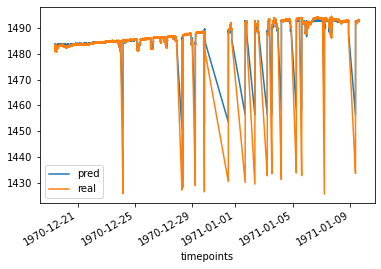

In [71]:
pred = model.predict(X_train)

rows = 3000000

pd.Series(pred[-rows:], index=y_train.iloc[-rows:].index).plot(label="pred")
y_trains[1].iloc[-rows:].plot(label="real")
plt.legend()
plt.show()

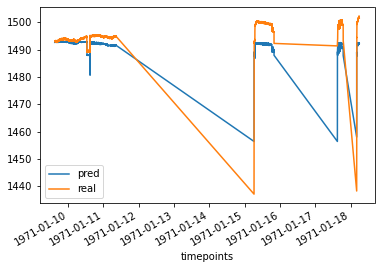

In [72]:
pred = model.predict(X_test)

pd.Series(pred, index=y_tests[1].index).plot(label="pred")
y_tests[1].plot(label="real")
plt.legend()
plt.show()

## Create Keras datasets

In [ ]:
test_size = 1000

kX = df[X_cols].copy()
ky = df[y_cols]

kX_train_df, kX_test_df, ky_train_df, ky_test_df = train_test_split(kX, ky, test_percent=0.1, offset_percent=0.9)
kX_train_df

In [ ]:
def lstm_data_transform(x_data, y_data, num_steps=5):
    """ Changes data to the format for LSTM training 
for sliding window approach """
    # Prepare the list for the transformed data
    X, y = list(), list()
    # Loop of the entire data set
    for i in range(x_data.shape[0]):
        # compute a new (sliding window) index
        end_ix = i + num_steps
        # if index is larger than the size of the dataset, we stop
        if end_ix >= x_data.shape[0]:
            break
        # Get a sequence of data for x
        seq_X = x_data[i:end_ix]
        # Get only the last element of the sequency for y
        seq_y = y_data[end_ix]
        # Append the list with sequencies
        X.append(seq_X)
        y.append(seq_y)
    # Make final arrays
    x_array = np.array(X)
    y_array = np.array(y)
    return x_array, y_array

ky_trains = [ky_train_df[c] for c in ky_train_df]
ky_tests = [ky_test_df[c] for c in ky_test_df]

j = 0
kX_train, ky_train = lstm_data_transform(kX_train_df, ky_trains[j], num_steps=30)
kX_test, ky_test = lstm_data_transform(kX_test_df, ky_tests[j], num_steps=30)

In [ ]:
kX_train.shape

In [ ]:
kX_train

## Train Keras models

In [ ]:
def train_keras(first, X_train, y_train, eval_set, epochs=20, batch_size=2048):
    
    norm = Normalization()
    norm.adapt(first(X_train))
    
    model = Sequential([
        first,
        norm,
        Dense(3),
        Dropout(0.4),
        Dense(3),
        Dense(3),
        Dense(3),
        Dense(3),
        Dense(1)
    ])

    model.compile(loss='mean_absolute_percentage_error', optimizer='adam')
    model.fit(X_train, y_train, validation_data=eval_set, epochs=epochs, batch_size=batch_size, verbose=1)
    
    return model

In [ ]:
lstm_model = train_keras(
    LSTM(5, input_shape=(kX_train.shape[1], kX_train.shape[2])),
    X_train = kX_train,
    y_train = ky_train,
    eval_set = (kX_test, ky_test),
    epochs=20
)

In [ ]:
gru_model = train_keras(
    GRU(10, input_shape=(kX_train.shape[1], kX_train.shape[2])),
    X_train = kX_train,
    y_train = ky_train,
    eval_set = (kX_test, ky_test),
    epochs=15
)

In [ ]:
tcn_model = train_keras(
    TCN(nb_filters=4, input_shape=(kX_train.shape[1], kX_train.shape[2])),
    X_train = kX_train,
    y_train = ky_train,
    eval_set = (kX_test, ky_test),
    epochs=10
)